In [5]:
import torch
import torchvision
import torchvision.transforms as T
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, random
from torchvision.transforms import Normalize
import cv2
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


In [6]:

class Unnormalize:
    """Converts an image tensor that was previously Normalize'd
    back to an image with pixels in the range [0, 1]."""
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        mean = torch.as_tensor(self.mean, dtype=tensor.dtype, device=tensor.device).view(3, 1, 1)
        std = torch.as_tensor(self.std, dtype=tensor.dtype, device=tensor.device).view(3, 1, 1)
        return torch.clamp(tensor*std + mean, 0., 1.)


mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
normalize_transform = Normalize(mean, std)
unnormalize_transform = Unnormalize(mean, std)

In [7]:
image_size = 224
batch_size = 64
metadata=pd.read_csv(r"C:\\Users\\PC\Desktop\\CS464\\face-verification\\archive\\metadata.csv")
crops_dir=r"C:\\Users\\PC\Desktop\\CS464\\face-verification\\archive\\faces_224"

def random_hflip(img, p=0.5):
    """Random horizontal flip."""
    if random.random() < p:
        return cv2.flip(img, 1)
    else:
        return img

In [8]:
def load_image_and_label(filename, cls, crops_dir, image_size, augment):
    """Loads an image into a tensor. Also returns its label."""
    img = cv2.imread(os.path.join(crops_dir, filename))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if augment: 
        img = random_hflip(img)

    img = cv2.resize(img, (image_size, image_size))

    img = torch.tensor(img).permute((2, 0, 1)).float().div(255)
    img = normalize_transform(img)

    target = 1 if cls == "FAKE" else 0
    return img, target

In [9]:
class VideoDataset(Dataset):
    """Face crops dataset.

    Arguments:
        crops_dir: base folder for face crops
        df: Pandas DataFrame with metadata
        split: if "train", applies data augmentation
        image_size: resizes the image to a square of this size
        sample_size: evenly samples this many videos from the REAL
            and FAKE subfolders (None = use all videos)
        seed: optional random seed for sampling
    """
    def __init__(self, crops_dir, df, split, image_size, sample_size=None, seed=None):
        self.crops_dir = crops_dir
        self.split = split
        self.image_size = image_size
        
        if sample_size is not None:
            real_df = df[df["label"] == "REAL"]
            fake_df = df[df["label"] == "FAKE"]
            sample_size = np.min(np.array([sample_size, len(real_df), len(fake_df)]))
            print("%s: sampling %d from %d real videos" % (split, sample_size, len(real_df)))
            print("%s: sampling %d from %d fake videos" % (split, sample_size, len(fake_df)))
            real_df = real_df.sample(sample_size, random_state=seed)
            fake_df = fake_df.sample(sample_size, random_state=seed)
            self.df = pd.concat([real_df, fake_df])
        else:
            self.df = df

        num_real = len(self.df[self.df["label"] == "REAL"])
        num_fake = len(self.df[self.df["label"] == "FAKE"])
        print("%s dataset has %d real videos, %d fake videos" % (split, num_real, num_fake))

    def __getitem__(self, index):
        row = self.df.iloc[index]
        filename = row["videoname"][:-4] + ".jpg"
        cls = row["label"]
        return load_image_and_label(filename, cls, self.crops_dir, 
                                    self.image_size, self.split == "train")
    def __len__(self):
        return len(self.df)

In [13]:
# def make_splits(crops_dir, metadata_df, frac):
#     # Make a validation split. Sample a percentage of the real videos, 
#     # and also grab the corresponding fake videos.
#     frac=frac*2
#     real_rows = metadata_df[metadata_df["label"] == "REAL"]
#     real_df = real_rows.sample(frac=frac, random_state=666)
#     fake_df = metadata_df[metadata_df["original"].isin(real_df["videoname"])]
#     r=len(real_df)
#     f=len(fake_df)
#     real_1=real_df[:int(r/2)]
#     real_2=real_df[int(r/2):]
#     fake_1=fake_df[:int(f/2)]
#     fake_2=fake_df[int(f/2):]   
#     val_df = pd.concat([real_1, fake_1])
#     test_df=pd.concat([real_2, fake_2])

#     #shuffle
#     val_df=val_df.sample(frac=1,random_state=666)
#     test_df=test_df.sample(frac=1,random_state=666)

#     # The training split is the remaining videos.
#     train_df = metadata_df.loc[~(metadata_df.index.isin( val_df.index) | metadata_df.index.isin( test_df.index))]

#     return train_df, val_df, test_df
def make_splits(crops_dir, metadata_df, frac):
    # Make a validation split. Sample a percentage of the real videos, 
    # and also grab the corresponding fake videos.
    real_rows = metadata_df[metadata_df["label"] == "REAL"]
    real_df = real_rows.sample(frac=1, random_state=666)
    fake_df = metadata_df[metadata_df["original"].isin(real_df["videoname"])]
    fake_df=fake_df.sample(frac=1,random_state=666)[:len(real_df)]
    r=len(real_df)
    f=len(fake_df)

    real_1=real_df[:int(8*r/10)]
    real_2=real_df[int(8*r/10):int(9*r/10)]
    real_3=real_df[int(9*r/10):]
    fake_1=fake_df[:int(8*r/10)]
    fake_2=fake_df[int(8*r/10):int(9*r/10)]  
    fake_3=fake_df[int(9*r/10):] 

    val_df = pd.concat([real_2, fake_2])
    test_df=pd.concat([real_3, fake_3])
    train_df=pd.concat([real_1, fake_1])

    train_df=train_df.sample(frac=1,random_state=666)
    val_df=val_df.sample(frac=1,random_state=666)
    test_df=test_df.sample(frac=1,random_state=666)
    
    return train_df, val_df, test_df

In [14]:
def create_data_loaders(crops_dir, metadata_df, image_size, batch_size, num_workers):
    train_df, val_df,test_df = make_splits(crops_dir, metadata_df, frac=0.05)

    train_dataset = VideoDataset(crops_dir, train_df, "train", image_size, sample_size=None)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                              num_workers=num_workers, pin_memory=True)

    val_dataset = VideoDataset(crops_dir, val_df, "val", image_size, sample_size=None, seed=1234)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, 
                            num_workers=num_workers, pin_memory=True)
    
    test_dataset = VideoDataset(crops_dir, test_df, "test", image_size, sample_size=None, seed=4321)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, 
                            num_workers=num_workers, pin_memory=True)

    return train_loader, val_loader, test_loader

In [15]:
train_loader, val_loader, test_loader = create_data_loaders(crops_dir, metadata, image_size, 
                                               batch_size, num_workers=0)

train dataset has 13034 real videos, 13034 fake videos
val dataset has 1629 real videos, 1629 fake videos
test dataset has 1630 real videos, 1630 fake videos


In [ ]:
# class CNN(nn.Module):
#     def __init__(self):
#         super(CNN, self).__init__()

#         # Pamameters Initialization
#         input_shape = (3,224,224)
#         activation = nn.ReLU()
#         padding = 1
#         droprate = 0.1
#         epsilon=0.001

#         self.layer1 = nn.Sequential(
#             nn.BatchNorm2d(num_features=input_shape[0]),
#             nn.Conv2d(in_channels=input_shape[0], out_channels=16, kernel_size=3, stride=1, padding=padding),
#             activation,
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.BatchNorm2d(num_features=16, eps=epsilon)
#         )

#         self.layer2 = nn.Sequential(
#             nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=padding),
#             activation,
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.BatchNorm2d(num_features=32, eps=epsilon),
#             nn.Dropout2d(p=droprate)
#         )

#         self.layer3 = nn.Sequential(
#             nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=padding),
#             activation,
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.BatchNorm2d(num_features=64, eps=epsilon),
#             nn.Dropout2d(p=droprate)
#         )

#         self.layer4 = nn.Sequential(
#             nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=padding),
#             activation,
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.BatchNorm2d(num_features=128, eps=epsilon),
#             nn.Dropout2d(p=droprate)
#         )

#         self.layer5 = nn.Sequential(
#             nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=padding),
#             activation,
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.BatchNorm2d(num_features=256, eps=epsilon),
#             nn.Dropout2d(p=droprate)
#         )

#         self.layer6 = nn.Sequential(
#             nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=padding),
#             activation,
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.BatchNorm2d(num_features=512, eps=epsilon),
#             nn.Dropout2d(p=droprate)
#         )

#         self.layer7 = nn.Sequential(
#             nn.AdaptiveAvgPool2d(output_size=(1, 1)),
#             nn.Flatten(),
#             nn.Linear(512, 2),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.layer4(x)
#         x = self.layer5(x)
#         x = self.layer6(x)
#         x = self.layer7(x)
#         return x

# model = CNN()

In [22]:
"""
    Propsoed CNN architecture.
    
"""

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Pamameters Initialization
        input_shape = (3,224,224)
        activation = nn.Sigmoid()
        padding = 1
        droprate = 0.1
        epsilon=0.001

        self.layer1 = nn.Sequential(
            nn.BatchNorm2d(num_features=input_shape[0]),
            nn.Conv2d(in_channels=input_shape[0], out_channels=8, kernel_size=3, stride=1, padding=padding),
            activation,
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(num_features=8, eps=epsilon)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=padding),
            activation,
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(num_features=16, eps=epsilon),
            nn.Dropout2d(p=droprate)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=padding),
            activation,
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(num_features=32, eps=epsilon),
            nn.Dropout2d(p=droprate)
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=padding),
            activation,
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(num_features=64, eps=epsilon),
            nn.Dropout2d(p=droprate)
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=padding),
            activation,
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(num_features=128, eps=epsilon),
            nn.Dropout2d(p=droprate)
        )

        self.layer6 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=padding),
            activation,
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(num_features=256, eps=epsilon),
            nn.Dropout2d(p=droprate)
        )
        self.layer7 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=padding),
            activation,
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(num_features=512, eps=epsilon),
            nn.Dropout2d(p=droprate)
        )
        self.layer8 = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            nn.Flatten(),
            nn.Linear(512, 2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)

        return x

model = CNN()

In [ ]:

# class PixelNorm(nn.Module):
#     def __init__(self):
#         super(PixelNorm, self).__init__()

#     def forward(self, x):
#         return x / torch.sqrt(torch.mean(x**2, dim=1, keepdim=True) + 1e-8)


In [ ]:
# class Discriminator(nn.Module):
#     def __init__(self, img_size= 224 * 224, num_channels = 3, num_classes=2, fmap_base=16384, fmap_decay=1.0, fmap_max=512):
#         super(Discriminator, self).__init__()
#         self.img_size = img_size
#         self.num_channels = num_channels
#         self.num_classes = num_classes
#         self.fmap_base = fmap_base
#         self.fmap_decay = fmap_decay
#         self.fmap_max = fmap_max

#         self.fromrgb = nn.Conv2d(num_channels, int(self.get_nf(0)), kernel_size=1, stride=1, padding=0)
#         self.main = nn.Sequential(
#             GBlock(self.get_nf(1), self.get_nf(1), num_classes=num_classes),
#             GBlock(self.get_nf(1), self.get_nf(2), num_classes=num_classes),
#             GBlock(self.get_nf(2), self.get_nf(3), num_classes=num_classes),
#             GBlock(self.get_nf(3), self.get_nf(4), num_classes=num_classes),
#             GBlock(self.get_nf(4), self.get_nf(5), num_classes=num_classes),
#             GBlock(self.get_nf(5), self.get_nf(6), num_classes=num_classes),
#             GBlock(self.get_nf(6), self.get_nf(7), num_classes=num_classes),
#             GBlock(self.get_nf(7), self.get_nf(8), num_classes=num_classes),
#             nn.LeakyReLU(negative_slope=0.2),
#             nn.AdaptiveAvgPool2d((1, 1)),
#             nn.Flatten(start_dim=1)
#         )

#         if self.num_classes > 0:
#             self.fc = nn.Linear(self.get_nf(8), num_classes, bias=True)
#         else:
#             self.fc = nn.Linear(self.get_nf(8), 1, bias=True)

#     def forward(self, x, y=None):
#         h = F.leaky_relu(self.fromrgb(x), negative_slope=0.2)
#         h = self.main(h)
#         out = self.fc(h)
#         return out.squeeze()

#     def get_nf(self, stage):
#         return min(int(self.fmap_base / (2.0 ** (stage * self.fmap_decay))), self.fmap_max)

# class GBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, num_classes=0):
#         super(GBlock, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding)
#         self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding=padding)
#         self.act1 = nn.LeakyReLU(negative_slope=0.2)
#         self.act2 = nn.LeakyReLU(negative_slope=0.2)
#         self.norm1 = PixelNorm()
#         self.norm2 = PixelNorm()
#         self.skip_conv = nn.Conv2d(in_channels, out_channels, 1)
#         self.skip_norm = PixelNorm()
#         self.num_classes = num_classes
#         if self.num_classes > 0:
#             self.cbn1 = nn.BatchNorm2d(in_channels, num_classes)
#             self.cbn2 = nn.BatchNorm2d(out_channels, num_classes)
#         else:
#             self.cbn1 = nn.BatchNorm2d(in_channels)
#             self.cbn2 = nn.BatchNorm2d(out_channels)
    
#     def forward(self, x, y=None):
#         h = self

# model = Discriminator()

In [23]:
torch.cuda.empty_cache()
torch.cuda.is_available()

True

In [29]:
#Training phase imp:

device = torch.device("cuda")
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
best_val_loss = float('inf') # initialize with a very high value

for epoch in range(10):
    running_loss = 0.0
    print("epoch", epoch)
    for index, data in enumerate(train_loader):
        # print("input is ", data[0], "and label is ", data[1])
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if index % 100 == 99:    
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, index + 1, running_loss / 100))
            running_loss = 0.0
    # Validate the model on validation dataset
    val_loss = 0.0
    with torch.no_grad():
        for index, data in enumerate(val_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
        val_loss /= len(val_loader)

    print('[%d] validation loss: %.3f' % (epoch + 1, val_loss))

    # Save the model with the best validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')


epoch 0
[1,   100] loss: 0.699
[1,   200] loss: 0.693
[1,   300] loss: 0.693
[1,   400] loss: 0.693
[1] validation loss: 0.694
epoch 1
[2,   100] loss: 0.694
[2,   200] loss: 0.693
[2,   300] loss: 0.691
[2,   400] loss: 0.691
[2] validation loss: 0.694
epoch 2
[3,   100] loss: 0.688
[3,   200] loss: 0.682
[3,   300] loss: 0.680
[3,   400] loss: 0.675
[3] validation loss: 0.665
epoch 3
[4,   100] loss: 0.660
[4,   200] loss: 0.667
[4,   300] loss: 0.675
[4,   400] loss: 0.658
[4] validation loss: 0.650
epoch 4
[5,   100] loss: 0.653
[5,   200] loss: 0.654
[5,   300] loss: 0.653
[5,   400] loss: 0.651
[5] validation loss: 0.653
epoch 5
[6,   100] loss: 0.646
[6,   200] loss: 0.646
[6,   300] loss: 0.654
[6,   400] loss: 0.654
[6] validation loss: 0.651
epoch 6
[7,   100] loss: 0.648
[7,   200] loss: 0.646
[7,   300] loss: 0.639
[7,   400] loss: 0.644
[7] validation loss: 0.661
epoch 7
[8,   100] loss: 0.641
[8,   200] loss: 0.643
[8,   300] loss: 0.637
[8,   400] loss: 0.639
[8] validat

In [30]:
def test_model(model, test_loader, checkpoint_path='best_model.pth'):
    # load the best model checkpoint
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint)
    model.eval()
 
    correct = 0
    total = 0
    with torch.no_grad():
        tp = 0
        fp = 0
        fn = 0 
        tn = 0
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            #TODO: For calculation of precision, accuracy, recall and F1 score, get related elements.
            
            for gt_label, pred_label in zip(labels, predicted):
                if (gt_label == 1 and pred_label == 1):
                    tp = tp + 1
                if (gt_label == 0 and pred_label == 1):
                    fp = fp + 1
                if (gt_label == 1 and pred_label == 0):
                    fn = fn + 1
                if (gt_label == 0 and pred_label == 0):
                    tn = tn + 1
    print(fp, fn, tp, tn)
    print('Accuracy of the network on the test images: %d %%' % (
        100 * correct / total))
    return correct, fp, fn, tp, tn
correct, fp, fn, tp, tn = test_model(model, test_loader, 'best_model.pth')


454 702 928 1176
Accuracy of the network on the test images: 64 %


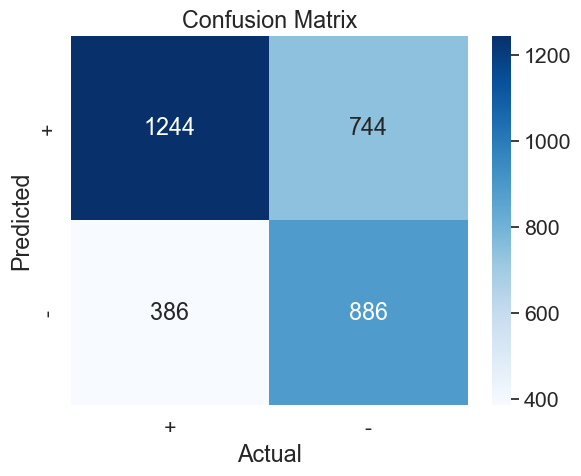

In [26]:
import seaborn as sns
def showcm(fp,fn,tp,tn):

        labels = ['+', '-']
        
        # Create the matrix
        confusion_matrix = np.array([[tp, fp],
                                    [fn, tn]])

        # Plot the matrix
        sns.set(font_scale=1.4)
        sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

        # Set plot properties
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title('Confusion Matrix')
        plt.show()
showcm(fp, fn, tp, tn)

In [27]:
# Print the true positive, true negative, false positive, and false negative values
print("True Positive (TP): ", tp)
print("True Negative (TN): ", tn)
print("False Positive (FP): ", fp)
print("False Negative (FN): ", fn)
 
# Calculate accuracy
accuracy = (tp + tn) / (tp + tn + fp + fn)
 
# Calculate precision
precision = tp / (tp + fp)
 
# Calculate recall
recall = tp / (tp + fn)
 
# Calculate F1-score
f1_score = 2 * (precision * recall) / (precision + recall)

# Print the accuracy, precision, recall, and F1-score
print("\n\nMetrics:")
print("Accuracy: ", round(accuracy, 2))
print("Precision: ", round(precision, 2))
print("Recall: ", round(recall, 2))
print("F1-score: ", round(f1_score, 2))

True Positive (TP):  1244
True Negative (TN):  886
False Positive (FP):  744
False Negative (FN):  386


Metrics:
Accuracy:  0.65
Precision:  0.63
Recall:  0.76
F1-score:  0.69


In [28]:
from torchsummary import summary
summary(model, [3,224,224])

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 8, 112, 112]         --
|    └─BatchNorm2d: 2-1                  [-1, 3, 224, 224]         6
|    └─Conv2d: 2-2                       [-1, 8, 224, 224]         224
|    └─Sigmoid: 2-3                      [-1, 8, 224, 224]         --
├─Sequential: 1                          []                        --
|    └─Sigmoid: 2-4                      [-1, 8, 224, 224]         --
├─Sequential: 1                          []                        --
|    └─Sigmoid: 2-5                      [-1, 8, 224, 224]         --
├─Sequential: 1                          []                        --
|    └─Sigmoid: 2-6                      [-1, 8, 224, 224]         --
├─Sequential: 1                          []                        --
|    └─Sigmoid: 2-7                      [-1, 8, 224, 224]         --
├─Sequential: 1                          []                        --
|    └─Sigmoid:

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 8, 112, 112]         --
|    └─BatchNorm2d: 2-1                  [-1, 3, 224, 224]         6
|    └─Conv2d: 2-2                       [-1, 8, 224, 224]         224
|    └─Sigmoid: 2-3                      [-1, 8, 224, 224]         --
├─Sequential: 1                          []                        --
|    └─Sigmoid: 2-4                      [-1, 8, 224, 224]         --
├─Sequential: 1                          []                        --
|    └─Sigmoid: 2-5                      [-1, 8, 224, 224]         --
├─Sequential: 1                          []                        --
|    └─Sigmoid: 2-6                      [-1, 8, 224, 224]         --
├─Sequential: 1                          []                        --
|    └─Sigmoid: 2-7                      [-1, 8, 224, 224]         --
├─Sequential: 1                          []                        --
|    └─Sigmoid:

In [ ]:
# lt2=[lt[a] for a in range(len(lt)) if a % 3 == 1 ]
def plot_loss(epochs, loss, val_loss):
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'orange', label = 'Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

def plot_accuracy(epochs, acc, val_acc):
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'orange', label = 'Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()
plot_accuracy(range(1, len(av3) + 1), at3, av3)
plot_loss(range(1, len(lt2) + 1), lt2, lv)